# Analysis of data of animals outcomes of the Austin Animal Shelter 
September, 16th, 2022
<br> Natalia Blinnikova

## Aim: to find out what factors may influence the probability of an animal to leave the shelter to home and build a model that may predict if it leaves the shelter to home or to some other destination. 

### Source of data: 
Austin Animal Shelter 
1. [Austin Animal Center Shelter Outcomes](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238)
2. [Austin Animal Center Shelter Intakes](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm)

## Content
<br> Cleaning and understanding the data for outcomes
<br> Cleaning and understanding the data for intakes
<br> Exploratory analysis of merged dataset with intakes and outcomes 
<br> Exploration of data for modeling
<br> Building the models for predictions 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk 
import traceback
import re
from datetime import datetime 

## Cleaning and understanding the data

### Checking data for outakes

In [ ]:
data = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


In [ ]:
display(data.loc[data.duplicated(keep=False) == True].head(4))
data.drop_duplicates(inplace=True)
data.duplicated(keep=False).sum()
#check for duplicates and later on drop of them

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
7820,A846569,A846569,12/04/2021 10:34:00 AM,Dec 2021,06/15/2021,Adoption,NaN,Dog,Neutered Male,5 months,Australian Cattle Dog Mix,Red Tick
7821,A846569,A846569,12/04/2021 10:34:00 AM,Dec 2021,06/15/2021,Adoption,NaN,Dog,Neutered Male,5 months,Australian Cattle Dog Mix,Red Tick
9836,A815987,Princess,04/13/2020 04:56:00 PM,Apr 2020,04/02/2019,Return to Owner,NaN,Dog,Intact Female,1 year,Cairn Terrier,White/Brown
9837,A815987,Princess,04/13/2020 04:56:00 PM,Apr 2020,04/02/2019,Return to Owner,NaN,Dog,Intact Female,1 year,Cairn Terrier,White/Brown


0

In [ ]:
data.shape

(143827, 12)

In [ ]:
data.dtypes

Animal ID           object
Name                object
DateTime            object
MonthYear           object
Date of Birth       object
Outcome Type        object
Outcome Subtype     object
Animal Type         object
Sex upon Outcome    object
Age upon Outcome    object
Breed               object
Color               object
dtype: object

In [ ]:
#convert datas into datetime object to make it easier to work with

def convert_date(datik):
    try: 
        return datetime.strptime(datik, '%m/%d/%Y')
    except: 
        try: 
            return datetime.strptime(datik, '%m/%d/%Y %I:%M:%S %p')
        except:
            print(datik)
            pass
data['DateTime'] = data.DateTime.apply(convert_date)
data['Date of Birth'] = data['Date of Birth'].apply(convert_date)

In [ ]:
data.dtypes

Animal ID                   object
Name                        object
DateTime            datetime64[ns]
MonthYear                   object
Date of Birth       datetime64[ns]
Outcome Type                object
Outcome Subtype             object
Animal Type                 object
Sex upon Outcome            object
Age upon Outcome            object
Breed                       object
Color                       object
dtype: object

In [ ]:
for column in list(data.columns)[5:]:
    print(column + ' for this column there are values:')
    print(data[column].unique()[:10])
    print('Count of unique values: ' + str(data[column].nunique()))

Outcome Type for this column there are values:
['Rto-Adopt' 'Adoption' 'Euthanasia' 'Transfer' 'Return to Owner' 'Died'
 'Disposal' 'Missing' 'Relocate' nan]
Count of unique values: 11
Outcome Subtype for this column there are values:
[nan 'Partner' 'Foster' 'SCRP' 'Out State' 'Suffering' 'Underage' 'Snr'
 'Rabies Risk' 'In Kennel']
Count of unique values: 26
Animal Type for this column there are values:
['Cat' 'Dog' 'Other' 'Bird' 'Livestock']
Count of unique values: 5
Sex upon Outcome for this column there are values:
['Neutered Male' 'Unknown' 'Intact Male' 'Spayed Female' 'Intact Female'
 nan]
Count of unique values: 5
Age upon Outcome for this column there are values:
['2 years' '1 year' '4 months' '6 days' '7 years' '2 months' '2 days'
 '3 weeks' '11 years' '9 months']
Count of unique values: 54
Breed for this column there are values:
['Domestic Shorthair Mix' 'Chihuahua Shorthair Mix' 'Raccoon'
 'Anatol Shepherd/Labrador Retriever'
 'American Foxhound/Labrador Retriever' 'Domest

#### Some possible interpretations of outcomes 

* Adoption the animal was adopted to a home 
* Barn Adoption the animal was adopted to live in a barn
* Offsite Missing the animal went missing for unknown reasons at an offsite partner location
* In-Foster Missing the animal is missing after being placed in a foster home (передержка)
* In-Kennel Missing the animal is missing after being transferred to a kennel facility (бридинговый центр?)
* Possible Theft Although not confirmed, the animal went missing as a result of theft from the facility
* Barn Transfer The animal was transferred to a facility for adoption into a barn environment
* SNR SNR refers to the city of Austin's Shelter-Neuter-Release program. I believe the outcome is representative of the animal being released.
#### Understanding meanings of some variables 
<br> I assume that date in the dataset - is a date of the outcome. 
<br> Livestock are the animals raised for agricultural reasons (cows, sheep, horse...)
<br> Intact or Spayed mean that reproduction organs have been removed. 
<br> Rabies is бешенство
#### Checking nan_values
The dataset is very clean of nan. 
<br> I will not remove name from the dataset because there might be possbility that animal with (or without) names have more positive outcomes. 
<br> 50% of nans in outcomes subtype is understandable as not all outcomes have any subtype, I am not even sure if I need to keep this column.
<br> there are 0,01% of nans in outcomes or 23 cases. As outcome is our target variable, I need this variable to be clean of nans, so I would just remove nans from this variable. 
<br> I will replace Nan in Age upon Outcome, as it might be important variable (replacement was a bit weird first replacing NaN with str, because all other values except NaN were strings)


In [ ]:
data.isna().mean()

Animal ID           0.000000
Name                0.292546
DateTime            0.000000
MonthYear           0.000000
Date of Birth       0.000000
Outcome Type        0.000160
Outcome Subtype     0.541505
Animal Type         0.000000
Sex upon Outcome    0.000007
Age upon Outcome    0.000229
Breed               0.000000
Color               0.000000
dtype: float64

In [ ]:
data.isna().sum()

Animal ID               0
Name                42076
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type           23
Outcome Subtype     77883
Animal Type             0
Sex upon Outcome        1
Age upon Outcome       33
Breed                   0
Color                   0
dtype: int64

In [ ]:
data['Age upon Outcome'].fillna('some age', inplace=True)

In [ ]:
def age(row): 
    if row['Age upon Outcome'] == 'some age':
        years = row['DateTime'].year - row['Date of Birth'].year
        months = row['DateTime'].month - row['Date of Birth'].month
        if years > 1 and months > 1: 
            to_return = str(years) + ' ' + 'years '+ str(months) + ' months'
        elif years == 1 and months > 1: 
            to_return = str(years) + ' ' + 'year '+ str(months) + ' months'
        elif years > 1 and months == 0: 
            to_return = str(years) + ' years'
        elif years == 0 and months > 1: 
            to_return = str(months) + ' months'
        elif years == 1 and months == 1: 
            to_return = str(years) + ' ' + 'year '+ str(months) + ' month'
        elif years == 1 and months == 0: 
            to_return = '1 year'
        elif years == 0 and months == 1: 
            to_return = '1 month'
        else: 
            to_return = str(years) + ' ' + 'years '+ str(months) + ' months'
    else:
        to_return = row['Age upon Outcome']
    return to_return 
    

        


In [ ]:
data.apply(lambda row: age(row), axis=1)

0          2 years
1           1 year
2           1 year
3         4 months
4           6 days
            ...   
143840     7 years
143841     2 years
143842      1 year
143843     2 years
143844    3 months
Length: 143827, dtype: object

In [ ]:
data.dropna(subset = ['Outcome Type'], inplace=True)

In [ ]:
data.loc[data['Sex upon Outcome'].isna()]

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
77531,A667395,Diego,2013-11-27 16:11:00,Nov 2013,2006-11-17,Return to Owner,NaN,Dog,NaN,7 years,Dachshund,Brown Merle


In [ ]:
data['Sex upon Outcome'].fillna('Male', inplace=True)
#because an animal with the name Diego must be a male

In [ ]:
data['Name'].fillna('NoName', inplace=True)
#in order to perform groupings as the presence of absence of a name might be important. 

In [ ]:
data['Outcome Subtype'].fillna('NoSubtype', inplace=True)

In [ ]:
data.isna().mean()

Animal ID           0.0
Name                0.0
DateTime            0.0
MonthYear           0.0
Date of Birth       0.0
Outcome Type        0.0
Outcome Subtype     0.0
Animal Type         0.0
Sex upon Outcome    0.0
Age upon Outcome    0.0
Breed               0.0
Color               0.0
dtype: float64

I am going to add age in days in order to perform correlation matrix easier

In [ ]:
def age_days(timedelt): 
    age_in_days = int(timedelt.days)
    return age_in_days

In [ ]:
data['ageInDays'] = data['DateTime'] - data['Date of Birth']

In [ ]:
data['ageInDays'] = data['ageInDays'].apply(age_days)

In [ ]:
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,ageInDays
0,A794011,Chunk,2019-05-08 18:20:00,May 2019,2017-05-02,Rto-Adopt,NoSubtype,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White,736
1,A776359,Gizmo,2018-07-18 16:02:00,Jul 2018,2017-07-12,Adoption,NoSubtype,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown,371
2,A821648,NoName,2020-08-16 11:38:00,Aug 2020,2019-08-16,Euthanasia,NoSubtype,Other,Unknown,1 year,Raccoon,Gray,366
3,A720371,Moose,2016-02-13 17:59:00,Feb 2016,2015-10-08,Adoption,NoSubtype,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff,128
4,A674754,NoName,2014-03-18 11:47:00,Mar 2014,2014-03-12,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,6


### Later in the analysis I have found that there are lots of duplicates in the data by animal id and it is not really clear, why. Perhaps, animals have been in the shelter for several times and I think these animals should be analysed separetely. Why they have returned to the shelter? Are there any patterns?

In [ ]:
data['Animal ID'].duplicated().sum()

15047

In [ ]:
data['Animal ID'].nunique()

128757

In [ ]:
data.loc[data['Animal ID'].duplicated(keep=False)==True].sort_values('Animal ID')

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,ageInDays
109859,A006100,Scamp,2017-12-07 00:00:00,Dec 2017,2007-07-09,Return to Owner,NoSubtype,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,3804
61410,A006100,Scamp,2014-12-20 16:35:00,Dec 2014,2007-07-09,Return to Owner,NoSubtype,Dog,Neutered Male,7 years,Spinone Italiano Mix,Yellow/White,2721
124724,A006100,Scamp,2014-03-08 17:10:00,Mar 2014,2007-07-09,Return to Owner,NoSubtype,Dog,Neutered Male,6 years,Spinone Italiano Mix,Yellow/White,2434
98181,A245945,Boomer,2014-07-04 15:26:00,Jul 2014,2000-05-23,Return to Owner,NoSubtype,Dog,Neutered Male,14 years,Labrador Retriever Mix,Tan,5155
75294,A245945,Boomer,2015-05-25 11:49:00,May 2015,2000-05-23,Transfer,Partner,Dog,Neutered Male,15 years,Labrador Retriever Mix,Tan,5480
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59215,A863101,Penny,2022-08-10 16:38:00,Aug 2022,2019-08-06,Transfer,Partner,Dog,Intact Female,3 years,Staffordshire Mix,Blue/White,1100
104198,A863102,Star,2022-08-04 17:55:00,Aug 2022,2015-08-04,Return to Owner,NoSubtype,Dog,Spayed Female,7 years,Staffordshire Mix,Tan/White,2557
43000,A863102,Star,2022-08-10 16:38:00,Aug 2022,2015-08-04,Transfer,Partner,Dog,Spayed Female,7 years,Staffordshire Mix,Tan/White,2563
143766,A863304,*Apple Juice,2022-09-03 16:55:00,Sep 2022,2020-08-08,Adoption,NoSubtype,Other,Intact Female,2 years,Californian,White/Brown,756


In [ ]:
last_time = data.groupby('Animal ID').agg({'DateTime': 'max'}).reset_index()
last_time.shape

(128757, 2)

In [ ]:
last_shelter = last_time.merge(data, how='left')
last_shelter.shape

(128757, 13)

In [ ]:
last_shelter.head()

,Animal ID,DateTime,Name,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,ageInDays
0,A006100,2017-12-07 00:00:00,Scamp,Dec 2017,2007-07-09,Return to Owner,NoSubtype,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,3804
1,A047759,2014-04-07 15:12:00,Oreo,Apr 2014,2004-04-02,Transfer,Partner,Dog,Neutered Male,10 years,Dachshund,Tricolor,3657
2,A134067,2013-11-16 11:54:00,Bandit,Nov 2013,1997-10-16,Return to Owner,NoSubtype,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White,5875
3,A141142,2013-11-17 11:40:00,Bettie,Nov 2013,1998-06-01,Return to Owner,NoSubtype,Dog,Spayed Female,15 years,Labrador Retriever/Pit Bull,Black/White,5648
4,A163459,2014-11-14 19:28:00,Sasha,Nov 2014,1999-10-19,Return to Owner,NoSubtype,Dog,Intact Female,15 years,Miniature Schnauzer Mix,Black/Gray,5505


In [ ]:
data.to_csv('austin_out_noNaN.csv', index=False)
last_shelter.to_csv('austin_out_noNanDups.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk 
import traceback
import re
from datetime import datetime 
df = pd.read_csv('austin_out_noNanDups.csv')
df.head()

,Animal ID,DateTime,Name,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,ageInDays
0,A006100,2017-12-07 00:00:00,Scamp,Dec 2017,2007-07-09,Return to Owner,NoSubtype,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,3804
1,A047759,2014-04-07 15:12:00,Oreo,Apr 2014,2004-04-02,Transfer,Partner,Dog,Neutered Male,10 years,Dachshund,Tricolor,3657
2,A134067,2013-11-16 11:54:00,Bandit,Nov 2013,1997-10-16,Return to Owner,NoSubtype,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White,5875
3,A141142,2013-11-17 11:40:00,Bettie,Nov 2013,1998-06-01,Return to Owner,NoSubtype,Dog,Spayed Female,15 years,Labrador Retriever/Pit Bull,Black/White,5648
4,A163459,2014-11-14 19:28:00,Sasha,Nov 2014,1999-10-19,Return to Owner,NoSubtype,Dog,Intact Female,15 years,Miniature Schnauzer Mix,Black/Gray,5505


### Checking data for intakes
I will remove columns which are not useful in further analysis
<br> I convert date to datetime 
<br> And them I will merge intakes data with dataset with outtakes 

In [ ]:
intakes = pd.read_csv('Austin_Animal_Center_Intakes.csv')
intakes.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,*Brock,01/03/2019 04:19:00 PM,January 2019,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Belle,07/05/2015 12:59:00 PM,July 2015,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Runster,04/14/2016 06:43:00 PM,April 2016,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,NaN,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A857105,Johnny Ringo,05/12/2022 12:23:00 AM,May 2022,4404 Sarasota Drive in Austin (TX),Public Assist,Normal,Cat,Neutered Male,2 years,Domestic Shorthair,Orange Tabby


In [ ]:
intakes_left = intakes[['Animal ID', 'DateTime', 'Intake Type', 'Intake Condition']]
intakes_left.rename(columns = {'DateTime' : 'Intake_date'}, inplace=True)


In [ ]:
intakes_left.head()

,Animal ID,Intake_date,Intake Type,Intake Condition
0,A786884,01/03/2019 04:19:00 PM,Stray,Normal
1,A706918,07/05/2015 12:59:00 PM,Stray,Normal
2,A724273,04/14/2016 06:43:00 PM,Stray,Normal
3,A665644,10/21/2013 07:59:00 AM,Stray,Sick
4,A857105,05/12/2022 12:23:00 AM,Public Assist,Normal


In [ ]:
intakes_left['Intake_date'] = intakes_left.Intake_date.apply(convert_date)

<ipython-input-105-82bab8286385>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intakes_left['Intake_date'] = intakes_left.Intake_date.apply(convert_date)


In [ ]:
intakes_left.dtypes

Animal ID                   object
Intake_date         datetime64[ns]
Intake Type                 object
Intake Condition            object
dtype: object

In [ ]:
intakes_left.isna().mean()

Animal ID           0.0
Intake_date         0.0
Intake Type         0.0
Intake Condition    0.0
dtype: float64

In [ ]:
intakes_left.duplicated().sum()

24

In [ ]:
intakes_left.drop_duplicates(inplace=True)
intakes_left.duplicated().sum()

<ipython-input-131-5f08d499c709>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intakes_left.drop_duplicates(inplace=True)


0

In [ ]:
display(intakes_left.shape)
intakes_left.loc[intakes_left['Animal ID'].duplicated(keep=False)==True].sort_values('Animal ID')

(143964, 4)

,Animal ID,Intake_date,Intake Type,Intake Condition
4714,A006100,2014-12-19 10:21:00,Public Assist,Normal
99066,A006100,2014-03-07 14:26:00,Public Assist,Normal
21956,A006100,2017-12-07 14:07:00,Stray,Normal
107802,A245945,2014-07-03 17:55:00,Stray,Normal
133055,A245945,2015-05-20 22:34:00,Stray,Normal
...,...,...,...,...
28110,A863973,2022-08-18 13:12:00,Owner Surrender,Normal
46670,A864131,2022-08-21 11:22:00,Stray,Normal
143589,A864131,2022-08-31 12:08:00,Owner Surrender,Normal
143869,A864189,2022-09-02 12:02:00,Owner Surrender,Normal


In [ ]:
intakes_maxd = intakes_left.groupby('Animal ID').agg({'Intake_date':'max'}).reset_index()

In [ ]:
intakes = intakes_maxd.merge(intakes_left, how='left')
display(intakes.shape)
intakes.head()

(128905, 4)

,Animal ID,Intake_date,Intake Type,Intake Condition
0,A006100,2017-12-07 14:07:00,Stray,Normal
1,A047759,2014-04-02 15:55:00,Owner Surrender,Normal
2,A134067,2013-11-16 09:02:00,Public Assist,Injured
3,A141142,2013-11-16 14:46:00,Stray,Aged
4,A163459,2014-11-14 15:11:00,Stray,Normal


In [ ]:
intakes.isna().mean()

Animal ID           0.0
Intake_date         0.0
Intake Type         0.0
Intake Condition    0.0
dtype: float64

In [ ]:
intakes_left.to_csv('intakes_noNan.csv', index=False)
intakes.to_csv('intakes_noNanDups.csv', index=False)

I think it is optimal to make left-join based of the data with outtakes as it is shorter that with intakes perhaps because I have dropped some data from it.

In [ ]:
full_data = df.merge(intakes, how='left', on='Animal ID')

In [ ]:
full_data.head()

,Animal ID,DateTime,Name,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,ageInDays,Intake_date,Intake Type,Intake Condition
0,A006100,2017-12-07 00:00:00,Scamp,Dec 2017,2007-07-09,Return to Owner,NoSubtype,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,3804,2017-12-07 14:07:00,Stray,Normal
1,A047759,2014-04-07 15:12:00,Oreo,Apr 2014,2004-04-02,Transfer,Partner,Dog,Neutered Male,10 years,Dachshund,Tricolor,3657,2014-04-02 15:55:00,Owner Surrender,Normal
2,A134067,2013-11-16 11:54:00,Bandit,Nov 2013,1997-10-16,Return to Owner,NoSubtype,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White,5875,2013-11-16 09:02:00,Public Assist,Injured
3,A141142,2013-11-17 11:40:00,Bettie,Nov 2013,1998-06-01,Return to Owner,NoSubtype,Dog,Spayed Female,15 years,Labrador Retriever/Pit Bull,Black/White,5648,2013-11-16 14:46:00,Stray,Aged
4,A163459,2014-11-14 19:28:00,Sasha,Nov 2014,1999-10-19,Return to Owner,NoSubtype,Dog,Intact Female,15 years,Miniature Schnauzer Mix,Black/Gray,5505,2014-11-14 15:11:00,Stray,Normal


In [ ]:
display(full_data.isna().mean())
full_data.shape

Animal ID           0.000000
DateTime            0.000000
Name                0.000000
MonthYear           0.000000
Date of Birth       0.000000
Outcome Type        0.000000
Outcome Subtype     0.000000
Animal Type         0.000000
Sex upon Outcome    0.000000
Age upon Outcome    0.000000
Breed               0.000000
Color               0.000000
ageInDays           0.000000
Intake_date         0.006322
Intake Type         0.006322
Intake Condition    0.006322
dtype: float64

(128759, 16)

### ok, I see missing values in columns merged from intakes, this are animals who are in the outtake dataset but those who are not in the intakes dataset. I think I am not going to do anything with this as these columns might not be necessary all the time in the analysis and if I need them I will remove the nans.

In [ ]:
full_data.to_csv('inout_austin_nodups_nans.csv', index=False)

### Exploratory data analysis 
Lets build some grahts just to think about correlations and dependances. 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk 
import traceback
import re
from datetime import datetime 
import matplotlib.pyplot as plt

In [ ]:
fdata = pd.read_csv('inout_austin_nodups_nans.csv')
display(fdata.columns)
fdata.head()

Index(['Animal ID', 'DateTime', 'Name', 'MonthYear', 'Date of Birth',
       'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome',
       'Age upon Outcome', 'Breed', 'Color', 'ageInDays', 'Intake_date',
       'Intake Type', 'Intake Condition'],
      dtype='object')

,Animal ID,DateTime,Name,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,ageInDays,Intake_date,Intake Type,Intake Condition
0,A006100,2017-12-07 00:00:00,Scamp,Dec 2017,2007-07-09,Return to Owner,NoSubtype,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,3804,2017-12-07 14:07:00,Stray,Normal
1,A047759,2014-04-07 15:12:00,Oreo,Apr 2014,2004-04-02,Transfer,Partner,Dog,Neutered Male,10 years,Dachshund,Tricolor,3657,2014-04-02 15:55:00,Owner Surrender,Normal
2,A134067,2013-11-16 11:54:00,Bandit,Nov 2013,1997-10-16,Return to Owner,NoSubtype,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White,5875,2013-11-16 09:02:00,Public Assist,Injured
3,A141142,2013-11-17 11:40:00,Bettie,Nov 2013,1998-06-01,Return to Owner,NoSubtype,Dog,Spayed Female,15 years,Labrador Retriever/Pit Bull,Black/White,5648,2013-11-16 14:46:00,Stray,Aged
4,A163459,2014-11-14 19:28:00,Sasha,Nov 2014,1999-10-19,Return to Owner,NoSubtype,Dog,Intact Female,15 years,Miniature Schnauzer Mix,Black/Gray,5505,2014-11-14 15:11:00,Stray,Normal


In [ ]:
def fruction_age(days): 
    months = days/30 
    if months <= 1.0: 
        tr = 'up to month'
    elif months > 1.0 and months <=6.0:
        tr = '1-6 months'
    elif months > 6.0 and months <=12.0:
        tr = '6-12 months'
    elif months > 12.0 and months <=24.0:
        tr = '1-2 years'
    elif months > 24 and months <=60:
        tr = '2-5 years'
    elif months > 60 and months <=120:
        tr = '5-10 years'
    elif months > 120 and months <=180:
        tr = '10-15 years'
    else:
        tr = 'more than 15 years'
    return tr

fdata['age_fruction'] = fdata.ageInDays.apply(fruction_age)

In [ ]:
fdata.age_fruction.unique()

array(['10-15 years', 'more than 15 years', '5-10 years', '2-5 years',
       '1-2 years', '6-12 months', '1-6 months', 'up to month'],
      dtype=object)

In [ ]:
intakes = list(fdata['Intake Condition'].unique())[::-1]
intakes

['Neurologic',
 'Agonal',
 'Med Attn',
 'Med Urgent',
 'Panleuk',
 'Space',
 'Neonatal',
 'Behavior',
 'Nursing',
 'Pregnant',
 'Feral',
 'Medical',
 'Other',
 nan,
 'Sick',
 'Aged',
 'Injured',
 'Normal']

<function matplotlib.pyplot.show(close=None, block=None)>

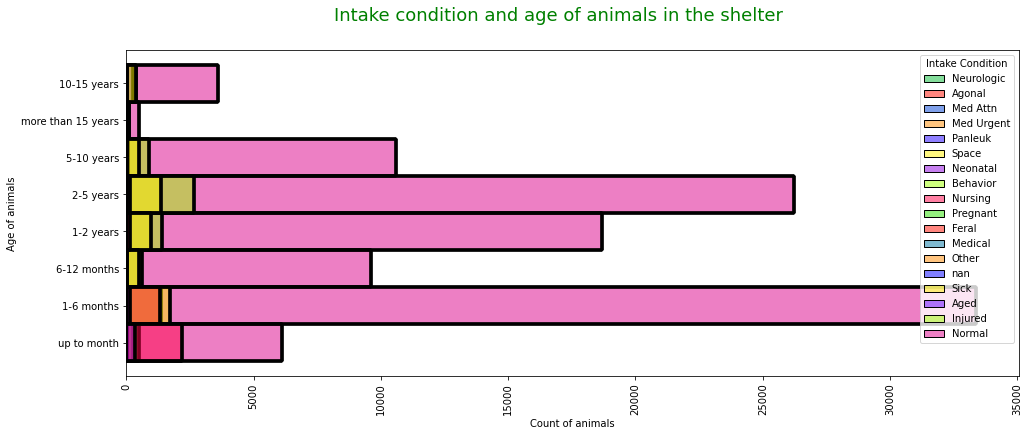

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(data=fdata, y='age_fruction', hue='Intake Condition', ax=ax, palette='prism', hue_order = intakes)
plt.xticks(rotation=90)
plt.xlabel('Count of animals')
plt.ylabel('Age of animals')
fig.suptitle('Intake condition and age of animals in the shelter', fontsize=18, color='Green')
plt.show

## Animals in what condition and in what age are coming to the shelter? 
Dominant amount of animals are coming to the shelter in normal condition, babies up to month are coming in nursing condition too (and this is expected). Some visible part of animals of 2-5 years are coming injured. 
<br> the dominant age of coming animals is from a month to 6 months, then 2-5 years and then 1-2 years (so from 0.5 to 5 years is the dominant age of coming animals)

In [ ]:
fdata['Intake Type'].fillna('Unknown', inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

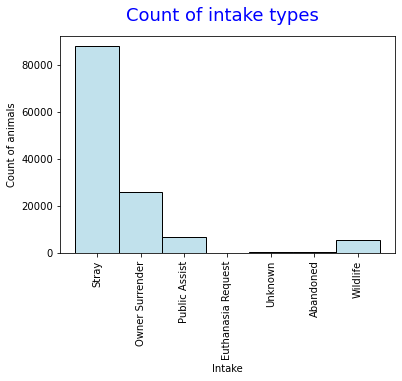

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=fdata, x='Intake Type', ax=ax, color='Lightblue')
plt.xticks(rotation=90)
plt.xlabel('Intake')
plt.ylabel('Count of animals')
fig.suptitle('Count of intake types', fontsize=18, color='Blue')
plt.show

## Animals from which sources are coming to the shelter? 

Stray animal adoption - is a not-profit organisation to help animals. 
<br> Owner surrender means that owner of the animal has brought an animal to the shelter

In [ ]:
fdata['Outcome Type'].unique()

array(['Return to Owner', 'Transfer', 'Relocate', 'Adoption',
       'Euthanasia', 'Died', 'Rto-Adopt', 'Missing', 'Disposal', 'Stolen',
       'Lost'], dtype=object)

In [ ]:
fdata['DateTime'] = pd.to_datetime(fdata['DateTime'])

In [ ]:
fdata.dtypes

Animal ID                   object
DateTime            datetime64[ns]
Name                        object
MonthYear                   object
Date of Birth               object
Outcome Type                object
Outcome Subtype             object
Animal Type                 object
Sex upon Outcome            object
Age upon Outcome            object
Breed                       object
Color                       object
ageInDays                    int64
Intake_date                 object
Intake Type                 object
Intake Condition            object
age_fruction                object
dtype: object

In [ ]:
fdata['month_year'] = fdata['DateTime'].dt.to_period('M')

In [ ]:
pandemic = fdata.groupby(['month_year', 'Outcome Type'])['Animal ID'].count().reset_index()
pandemic['month_year'] = pandemic['month_year'].astype(str)
pandemic.dtypes

month_year      object
Outcome Type    object
Animal ID        int64
dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

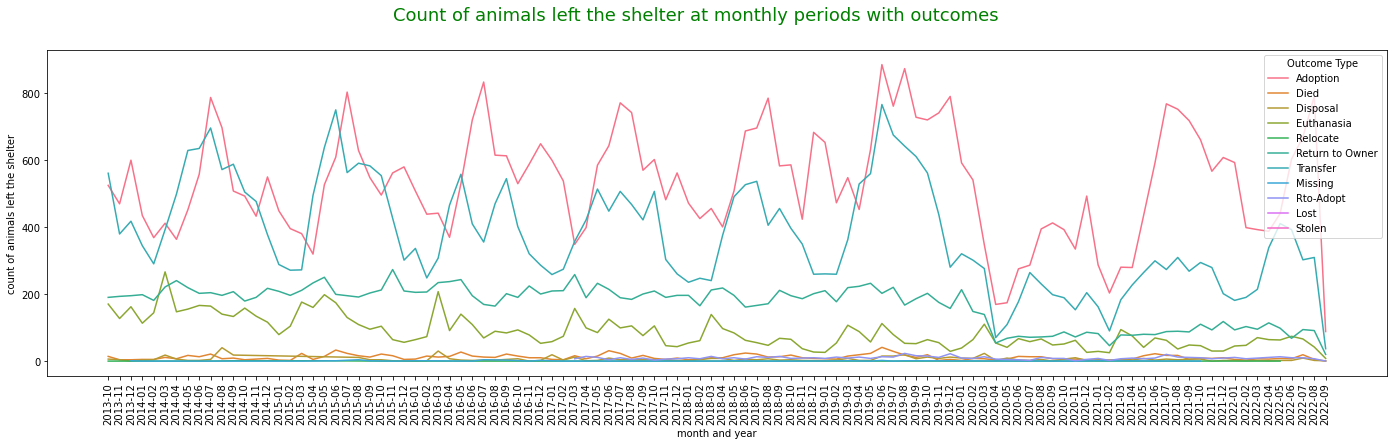

In [ ]:
fig, ax = plt.subplots(figsize=(24, 6))
sns.lineplot(data=pandemic, x='month_year', y='Animal ID', hue='Outcome Type', ax=ax)
plt.xticks(rotation=90)
plt.xlabel('month and year')
plt.ylabel('count of animals left the shelter')
fig.suptitle('Count of animals left the shelter at monthly periods with outcomes', fontsize=18, color='Green')
plt.show

## has pandemic influenced the animals' outcomes? 
Yes, it did, in March, 2020 there is visible drop in the counts of outcome what is back to high by summer 2021.
<br> Also there are observable drops in outtakes in winters in general. So people are more wiilling to adopt in summer.

In [ ]:
fdata['Animal Type'].value_counts()

Dog          68097
Cat          52373
Other         7575
Bird           688
Livestock       26
Name: Animal Type, dtype: int64

In [ ]:
typesOut = fdata.groupby(['Animal Type', 'Outcome Type'])['Animal ID'].count().reset_index()
typesOut['percent'] = typesOut.groupby(['Animal Type'])['Animal ID'].transform(lambda x: x/x.sum()*100)
typesOut.loc[typesOut['Animal Type'].isin(['Dog', 'Cat'])]

,Animal Type,Outcome Type,Animal ID,percent
8,Cat,Adoption,24666,47.096787
9,Cat,Died,799,1.525595
10,Cat,Disposal,95,0.181391
11,Cat,Euthanasia,2207,4.214003
12,Cat,Missing,33,0.063010
13,Cat,Relocate,5,0.009547
14,Cat,Return to Owner,2263,4.320929
15,Cat,Rto-Adopt,188,0.358964
16,Cat,Transfer,22117,42.229775
17,Dog,Adoption,31914,46.865501


<function matplotlib.pyplot.show(close=None, block=None)>

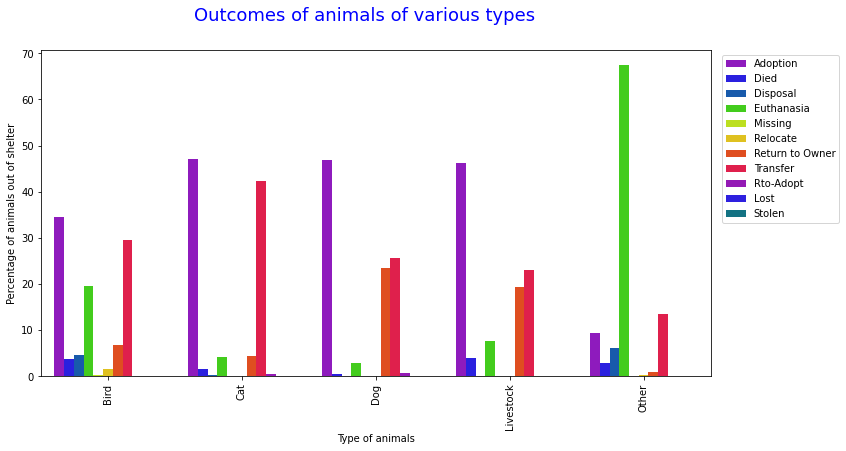

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=typesOut, x='Animal Type', y='percent', hue='Outcome Type', ax=ax, palette='prism')
plt.xticks(rotation=90)
plt.xlabel('Type of animals')
plt.ylabel('Percentage of animals out of shelter')
fig.suptitle('Outcomes of animals of various types', fontsize=18, color='Blue')
plt.legend(bbox_to_anchor=(1.2, 1.0), loc='upper right')
plt.show

## Is there difference between the outcome types of dogs and cats? 
Both types of animals are adopted equaly, but cats are twice more transfered than dogs and very little being returned to owner (4.3%) while dogs are equaly transfered or returned to owner (around 23-25%). Also both types are euthanasied equally. Also they have the same rate of RTO-adopt. What is this? Is it return-to-owner adopt? So what is the difference with just Return-to-Owner outcome? 
<br><br> The highest rates of euthanasia have birds and other animals. All other types of animals besides dogs and cats are equally lost (around 4%), birds are commonly transfered or RTO - aroun 30%, livestock is mostly RTO - close to 50%. 

### Exploration of data for modeling

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk 
import traceback
import re
from datetime import datetime 
import matplotlib.pyplot as plt
fdata = pd.read_csv('inout_austin_nodups_nans.csv')
fdata['DateTime'] = pd.to_datetime(fdata['DateTime'])

def fruction_age(days): 
    months = days/30 
    if months <= 1.0: 
        tr = 'up to month'
    elif months > 1.0 and months <=6.0:
        tr = '1-6 months'
    elif months > 6.0 and months <=12.0:
        tr = '6-12 months'
    elif months > 12.0 and months <=24.0:
        tr = '1-2 years'
    elif months > 24 and months <=60:
        tr = '2-5 years'
    elif months > 60 and months <=120:
        tr = '5-10 years'
    elif months > 120 and months <=180:
        tr = '10-15 years'
    else:
        tr = 'more than 15 years'
    return tr

fdata['age_fruction'] = fdata.ageInDays.apply(fruction_age)

fdata.columns

Index(['Animal ID', 'DateTime', 'Name', 'MonthYear', 'Date of Birth',
       'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome',
       'Age upon Outcome', 'Breed', 'Color', 'ageInDays', 'Intake_date',
       'Intake Type', 'Intake Condition', 'age_fruction'],
      dtype='object')

In [ ]:
#I will combine the variables values which are very close in their meaning
fdata.replace(['Relocate', 'Stolen', 'Lost'], 'Missing', inplace=True)
fdata.replace('Disposal', 'Died', inplace=True)
fdata.replace('Return to Owner', 'Rto-Adopt', inplace=True)
display(fdata['Outcome Type'].value_counts(normalize=True))

Adoption      0.446835
Transfer      0.316692
Rto-Adopt     0.147322
Euthanasia    0.072974
Died          0.015502
Missing       0.000676
Name: Outcome Type, dtype: float64

#### I am going to decide what models to use.  
<br>I may probably use logistic regression because I can classify outcomes by 2 types: Adoption&RTO-Adoption (animal went to a human) and all other outcomes which mean that animal didn't find home. 
<br><br>Decision tree - also possible and I can work with various targets.
<br><br> Clusterization - also possible as I know the number of clusters but they are not equal in size.
<br><br> <b>I will start with logistic</b>
* aren't variables multicolinear? 
* the size of the set is fairly large. 

In [ ]:
#I will need to drop na from columns with intakes as I need to perform analysis. 
fdata.dropna(inplace=True)
display(fdata.isna().sum())

Animal ID           0
DateTime            0
Name                0
MonthYear           0
Date of Birth       0
Outcome Type        0
Outcome Subtype     0
Animal Type         0
Sex upon Outcome    0
Age upon Outcome    0
Breed               0
Color               0
ageInDays           0
Intake_date         0
Intake Type         0
Intake Condition    0
age_fruction        0
dtype: int64

In [ ]:
#I want to create another variable for days in shelter as I belive it might be important
def age_days(timedelt): 
    age_in_days = int(timedelt.days)
    return age_in_days

fdata['Intake_date'] = pd.to_datetime(fdata['Intake_date'])
fdata['shelterDays'] = fdata['DateTime'] - fdata['Intake_date']
fdata['shelterDays'] = fdata['shelterDays'].apply(age_days)
fdata.head()

,Animal ID,DateTime,Name,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,ageInDays,Intake_date,Intake Type,Intake Condition,age_fruction,shelterDays
0,A006100,2017-12-07 00:00:00,Scamp,Dec 2017,2007-07-09,Rto-Adopt,NoSubtype,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,3804,2017-12-07 14:07:00,Stray,Normal,10-15 years,-1
1,A047759,2014-04-07 15:12:00,Oreo,Apr 2014,2004-04-02,Transfer,Partner,Dog,Neutered Male,10 years,Dachshund,Tricolor,3657,2014-04-02 15:55:00,Owner Surrender,Normal,10-15 years,4
2,A134067,2013-11-16 11:54:00,Bandit,Nov 2013,1997-10-16,Rto-Adopt,NoSubtype,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White,5875,2013-11-16 09:02:00,Public Assist,Injured,more than 15 years,0
3,A141142,2013-11-17 11:40:00,Bettie,Nov 2013,1998-06-01,Rto-Adopt,NoSubtype,Dog,Spayed Female,15 years,Labrador Retriever/Pit Bull,Black/White,5648,2013-11-16 14:46:00,Stray,Aged,more than 15 years,0
4,A163459,2014-11-14 19:28:00,Sasha,Nov 2014,1999-10-19,Rto-Adopt,NoSubtype,Dog,Intact Female,15 years,Miniature Schnauzer Mix,Black/Gray,5505,2014-11-14 15:11:00,Stray,Normal,more than 15 years,0


I am going to drop all weird data, where age or days in shelter are with minus values except for -1, as it might mean, that the animal is just 1 day old.

In [ ]:
fdata.drop(fdata.loc[fdata['ageInDays'] < -1].index, inplace=True)
fdata.drop(fdata.loc[fdata['shelterDays'] < -1].index, inplace=True)

In [ ]:
fdata['shelterDays'] = fdata['shelterDays'].replace(-1, 1)
fdata['ageInDays'] = fdata['ageInDays'].replace(-1, 1)

In [ ]:
display(fdata.isna().sum())
display(fdata.duplicated().sum())
fdata.shape
#after all the manipulations there are still almost 128 000 of instances of hopefully clean data. This is good. 
#as I have around 145000 but there were duplicates and missing values

Animal ID           0
DateTime            0
Name                0
MonthYear           0
Date of Birth       0
Outcome Type        0
Outcome Subtype     0
Animal Type         0
Sex upon Outcome    0
Age upon Outcome    0
Breed               0
Color               0
ageInDays           0
Intake_date         0
Intake Type         0
Intake Condition    0
age_fruction        0
shelterDays         0
dtype: int64

0

(127812, 18)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk 
import traceback
import re
from datetime import datetime 
import matplotlib.pyplot as plt

In [ ]:
fdata.to_csv('nominal_vars_austin_ML.csv')

In [ ]:
df = pd.read_csv('nominal_vars_austin_ML.csv')

In [ ]:
display(df.Color.nunique())

619

In [ ]:
def def_color(color):    
    for item in ['Yellow', 'Brown', 'Gold', 'Tan']:
        if item in color: 
            return 'BrownSome'
    for item in ['Black', 'Grey', 'Smoke', 'Chocolate']:
        if item in color: 
            return 'BlackGreySome'
    for item in ['White', 'Silver', 'Cream', 'Blue']:
        if item in color: 
            return 'WhiteSome'
    for item in ['Tricolor', 'Tiger', 'Tortie']:
        if item in color: 
            return 'Tricolor'
    for item in ['Red', 'Orange', 'Apricot']:
        if item in color: 
            return 'Redsome'
    return 'Othersome'   


colorsdf = df['Color']
less_clrs = colorsdf.apply(def_color)
display(less_clrs.unique())
less_clrs.nunique()

array(['BrownSome', 'Tricolor', 'BlackGreySome', 'WhiteSome', 'Redsome',
       'Othersome'], dtype=object)

6

In [ ]:
df['Less_color'] = df['Color'].apply(def_color)
df.Less_color.value_counts(normalize=True)

BrownSome        0.389909
BlackGreySome    0.257300
WhiteSome        0.199191
Othersome        0.065330
Redsome          0.045497
Tricolor         0.042774
Name: Less_color, dtype: float64

In [ ]:
df.loc[df['Name'].isin(['NoName']) == False, 'Name'] = 1
df.loc[df['Name'].isin(['NoName']) == True, 'Name'] = 0
df.head()

,Unnamed: 0,Animal ID,DateTime,Name,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,ageInDays,Intake_date,Intake Type,Intake Condition,age_fruction,shelterDays,Less_color
0,0,A006100,2017-12-07 00:00:00,1,Dec 2017,2007-07-09,Rto-Adopt,NoSubtype,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,3804,2017-12-07 14:07:00,Stray,Normal,10-15 years,1,BrownSome
1,1,A047759,2014-04-07 15:12:00,1,Apr 2014,2004-04-02,Transfer,Partner,Dog,Neutered Male,10 years,Dachshund,Tricolor,3657,2014-04-02 15:55:00,Owner Surrender,Normal,10-15 years,4,Tricolor
2,2,A134067,2013-11-16 11:54:00,1,Nov 2013,1997-10-16,Rto-Adopt,NoSubtype,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White,5875,2013-11-16 09:02:00,Public Assist,Injured,more than 15 years,0,BrownSome
3,3,A141142,2013-11-17 11:40:00,1,Nov 2013,1998-06-01,Rto-Adopt,NoSubtype,Dog,Spayed Female,15 years,Labrador Retriever/Pit Bull,Black/White,5648,2013-11-16 14:46:00,Stray,Aged,more than 15 years,0,BlackGreySome
4,4,A163459,2014-11-14 19:28:00,1,Nov 2014,1999-10-19,Rto-Adopt,NoSubtype,Dog,Intact Female,15 years,Miniature Schnauzer Mix,Black/Gray,5505,2014-11-14 15:11:00,Stray,Normal,more than 15 years,0,BlackGreySome


In [ ]:
display(df['Sex upon Outcome'].unique())
df.loc[df['Sex upon Outcome'].isin(['Spayed Female', 'Intact Female']) == True, 'Sex upon Outcome'] = 2
df.loc[df['Sex upon Outcome'].isin(['Neutered Male', 'Intact Male', 'Male']) == True, 'Sex upon Outcome'] = 1
df.loc[df['Sex upon Outcome'] == 'Unknown', 'Sex upon Outcome'] = 0
df.head()

array(['Neutered Male', 'Spayed Female', 'Intact Female', 'Unknown',
       'Intact Male', 'Male'], dtype=object)

,Unnamed: 0,Animal ID,DateTime,Name,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,ageInDays,Intake_date,Intake Type,Intake Condition,age_fruction,shelterDays,Less_color
0,0,A006100,2017-12-07 00:00:00,1,Dec 2017,2007-07-09,Rto-Adopt,NoSubtype,Dog,1,10 years,Spinone Italiano Mix,Yellow/White,3804,2017-12-07 14:07:00,Stray,Normal,10-15 years,1,BrownSome
1,1,A047759,2014-04-07 15:12:00,1,Apr 2014,2004-04-02,Transfer,Partner,Dog,1,10 years,Dachshund,Tricolor,3657,2014-04-02 15:55:00,Owner Surrender,Normal,10-15 years,4,Tricolor
2,2,A134067,2013-11-16 11:54:00,1,Nov 2013,1997-10-16,Rto-Adopt,NoSubtype,Dog,1,16 years,Shetland Sheepdog,Brown/White,5875,2013-11-16 09:02:00,Public Assist,Injured,more than 15 years,0,BrownSome
3,3,A141142,2013-11-17 11:40:00,1,Nov 2013,1998-06-01,Rto-Adopt,NoSubtype,Dog,2,15 years,Labrador Retriever/Pit Bull,Black/White,5648,2013-11-16 14:46:00,Stray,Aged,more than 15 years,0,BlackGreySome
4,4,A163459,2014-11-14 19:28:00,1,Nov 2014,1999-10-19,Rto-Adopt,NoSubtype,Dog,2,15 years,Miniature Schnauzer Mix,Black/Gray,5505,2014-11-14 15:11:00,Stray,Normal,more than 15 years,0,BlackGreySome


In [ ]:
#what if I categorize days in shelter? 
df.loc[df['shelterDays'] <=5, 'shelterDays'] = 1
df.loc[(df['shelterDays'] > 5) & (df['shelterDays'] <= 10), 'shelterDays'] = 2
df.loc[(df['shelterDays'] > 10) & (df['shelterDays'] <= 15), 'shelterDays'] = 3
df.loc[(df['shelterDays'] > 15) & (df['shelterDays'] <= 50), 'shelterDays'] = 4
df.loc[df['shelterDays'] > 50, 'shelterDays'] = 5

In [ ]:
df.age_fruction.unique()

array(['10-15 years', 'more than 15 years', '5-10 years', '2-5 years',
       '1-2 years', '6-12 months', '1-6 months', 'up to month'],
      dtype=object)

In [ ]:
agesW = list(df.age_fruction.unique())
ages = [7, 8, 6, 5, 4, 3, 2, 1]
for w, n in zip(agesW, ages): 
    df.loc[df['age_fruction'] == w, 'age_fruction'] = n

In [ ]:
df.columns

Index(['Unnamed: 0', 'Animal ID', 'DateTime', 'Name', 'MonthYear',
       'Date of Birth', 'Outcome Type', 'Outcome Subtype', 'Animal Type',
       'Sex upon Outcome', 'Age upon Outcome', 'Breed', 'Color', 'ageInDays',
       'Intake_date', 'Intake Type', 'Intake Condition', 'age_fruction',
       'shelterDays', 'Less_color'],
      dtype='object')

In [ ]:
dfN = df[['Name', 'Intake Type', 'Outcome Type', 'Animal Type', 'Sex upon Outcome', 'age_fruction', 'shelterDays','Less_color']]
dfN.head()

,Name,Intake Type,Outcome Type,Animal Type,Sex upon Outcome,age_fruction,shelterDays,Less_color
0,1,Stray,Rto-Adopt,Dog,1,7,1,BrownSome
1,1,Owner Surrender,Transfer,Dog,1,7,1,Tricolor
2,1,Public Assist,Rto-Adopt,Dog,1,8,1,BrownSome
3,1,Stray,Rto-Adopt,Dog,2,8,1,BlackGreySome
4,1,Stray,Rto-Adopt,Dog,2,8,1,BlackGreySome


In [ ]:
#I droped the data of animals being euthanasied under request as it is obvious correlation
index_euthanasia = dfN.loc[(dfN['Intake Type'] == 'Euthanasia Request') & (dfN['Outcome Type'] == 'Euthanasia')].index
dfN.drop(index_euthanasia, inplace=True)

C:\Users\ns.blinnikova\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
intakesLst = list(dfN['Intake Type'].unique())
intakes_codes = [1, 2, 3, 4, 5, 6]
for intake_type, code in zip(intakesLst, intakes_codes): 
    dfN.loc[dfN['Intake Type'] == intake_type, 'Intake Type'] = code 
dfN.head(10)

C:\Users\ns.blinnikova\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Name,Intake Type,Outcome Type,Animal Type,Sex upon Outcome,age_fruction,shelterDays,Less_color
0,1,1,Rto-Adopt,Dog,1,7,1,BrownSome
1,1,2,Transfer,Dog,1,7,1,Tricolor
2,1,3,Rto-Adopt,Dog,1,8,1,BrownSome
3,1,1,Rto-Adopt,Dog,2,8,1,BlackGreySome
4,1,1,Rto-Adopt,Dog,2,8,1,BlackGreySome
5,1,1,Rto-Adopt,Dog,1,8,1,BrownSome
6,0,1,Missing,Bird,0,8,1,WhiteSome
7,1,3,Rto-Adopt,Dog,1,8,2,BlackGreySome
8,1,1,Rto-Adopt,Dog,2,8,1,BrownSome
9,1,1,Rto-Adopt,Cat,2,8,1,BlackGreySome


In [ ]:
outakeLst = list(dfN['Outcome Type'].unique())
out_codes = list(range(1, len(outakeLst)+1, 1))
for intake_type, code in zip(outakeLst, out_codes): 
    dfN.loc[dfN['Outcome Type'] == intake_type, 'Outcome Type'] = code 
dfN.head(10)

C:\Users\ns.blinnikova\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Name,Intake Type,Outcome Type,Animal Type,Sex upon Outcome,age_fruction,shelterDays,Less_color
0,1,1,1,Dog,1,7,1,BrownSome
1,1,2,2,Dog,1,7,1,Tricolor
2,1,3,1,Dog,1,8,1,BrownSome
3,1,1,1,Dog,2,8,1,BlackGreySome
4,1,1,1,Dog,2,8,1,BlackGreySome
5,1,1,1,Dog,1,8,1,BrownSome
6,0,1,3,Bird,0,8,1,WhiteSome
7,1,3,1,Dog,1,8,2,BlackGreySome
8,1,1,1,Dog,2,8,1,BrownSome
9,1,1,1,Cat,2,8,1,BlackGreySome


In [ ]:
colorLst = list(dfN['Less_color'].unique())
color_codes = list(range(1, len(colorLst)+1, 1))
for intake_type, code in zip(colorLst, color_codes): 
    dfN.loc[dfN['Less_color'] == intake_type, 'Less_color'] = code 
dfN.head(5)

C:\Users\ns.blinnikova\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Name,Intake Type,Outcome Type,Animal Type,Sex upon Outcome,age_fruction,shelterDays,Less_color
0,1,1,1,Dog,1,7,1,1
1,1,2,2,Dog,1,7,1,2
2,1,3,1,Dog,1,8,1,1
3,1,1,1,Dog,2,8,1,3
4,1,1,1,Dog,2,8,1,3


In [ ]:
animalLst = list(dfN['Animal Type'].unique())
animal_codes = list(range(1, len(colorLst)+1, 1))
for intake_type, code in zip(animalLst, animal_codes): 
    dfN.loc[dfN['Animal Type'] == intake_type, 'Animal Type'] = code 
dfN.head(5)

C:\Users\ns.blinnikova\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Name,Intake Type,Outcome Type,Animal Type,Sex upon Outcome,age_fruction,shelterDays,Less_color
0,1,1,1,1,1,7,1,1
1,1,2,2,1,1,7,1,2
2,1,3,1,1,1,8,1,1
3,1,1,1,1,2,8,1,3
4,1,1,1,1,2,8,1,3


In [ ]:
dfN.shelterDays.unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [ ]:
dfN.to_csv('coded_animals.csv', index=False)

In [ ]:
df.loc[df['shelterDays'] <=5, 'shelterDays'] = 1
df.loc[(df['shelterDays'] > 5) & (df['shelterDays'] <= 10), 'shelterDays'] = 2
df.loc[(df['shelterDays'] > 10) & (df['shelterDays'] <= 15), 'shelterDays'] = 3
df.loc[(df['shelterDays'] > 15) & (df['shelterDays'] <= 50), 'shelterDays'] = 4
df.loc[df['shelterDays'] > 50, 'shelterDays'] = 5

In [ ]:
print('These are codes for outtakes')
display(list(zip(outakeLst, out_codes)))
print('These are codes for ages')
display(list(zip(agesW, ages)))
print('These are codes for intakes')
display(list(zip(intakesLst, intakes_codes)))
print('These are codes for sex: 0 - unknown, 1-male, 2-female')
print('These are codes for colors')
display(list(zip(colorLst, color_codes)))
print('These are codes for abimal types')
display(list(zip(animalLst, animal_codes)))
print('These are codes for days in shelter')
display('Less than 5:1 5-10 days:2 10-15 days:3 15-50 days:4 more than 50 days:5')




These are codes for outtakes


[('Rto-Adopt', 1),
 ('Transfer', 2),
 ('Missing', 3),
 ('Adoption', 4),
 ('Euthanasia', 5),
 ('Died', 6)]

These are codes for ages


[('10-15 years', 7),
 ('more than 15 years', 8),
 ('5-10 years', 6),
 ('2-5 years', 5),
 ('1-2 years', 4),
 ('6-12 months', 3),
 ('1-6 months', 2),
 ('up to month', 1)]

These are codes for intakes


[('Stray', 1),
 ('Owner Surrender', 2),
 ('Public Assist', 3),
 ('Euthanasia Request', 4),
 ('Abandoned', 5),
 ('Wildlife', 6)]

These are codes for sex: 0 - unknown, 1-male, 2-female
These are codes for colors


[('BrownSome', 1),
 ('Tricolor', 2),
 ('BlackGreySome', 3),
 ('WhiteSome', 4),
 ('Redsome', 5),
 ('Othersome', 6)]

These are codes for abimal types


[('Dog', 1), ('Bird', 2), ('Cat', 3), ('Other', 4), ('Livestock', 5)]

These are codes for days in shelter


'Less than 5:1 5-10 days:2 10-15 days:3 15-50 days:4 more than 50 days:5'

In [ ]:
dfN.Less_color.isna().sum()

0

### Building the ML model 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import traceback
import re
from datetime import datetime 
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('coded_animals.csv')
df.head()

,Name,Intake Type,Outcome Type,Animal Type,Sex upon Outcome,age_fruction,shelterDays,Less_color
0,1,1,1,1,1,7,1,1
1,1,2,2,1,1,7,1,2
2,1,3,1,1,1,8,1,1
3,1,1,1,1,2,8,1,3
4,1,1,1,1,2,8,1,3


In [ ]:
df.describe()

,Name,Intake Type,Outcome Type,Animal Type,Sex upon Outcome,age_fruction,shelterDays,Less_color
count,127610.000000,127610.000000,127610.000000,127610.000000,127610.000000,127610.000000,127610.000000,127610.000000
mean,0.674297,1.560199,3.022122,1.997014,1.353812,3.656853,2.142732,2.663655
std,0.468639,1.141420,1.335325,1.083415,0.636985,1.691684,1.447432,1.568030
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
50%,1.000000,1.000000,4.000000,1.000000,1.000000,4.000000,1.000000,3.000000
75%,1.000000,2.000000,4.000000,3.000000,2.000000,5.000000,4.000000,4.000000
max,1.000000,6.000000,6.000000,5.000000,2.000000,8.000000,5.000000,6.000000


In [ ]:
df.corr()

,Name,Intake Type,Outcome Type,Animal Type,Sex upon Outcome,age_fruction,shelterDays,Less_color
Name,1.000000,-0.136046,-0.079838,-0.344154,0.262579,0.299680,0.345186,-0.040710
Intake Type,-0.136046,1.000000,0.247302,0.277154,-0.352359,0.136364,-0.104297,-0.075251
Outcome Type,-0.079838,0.247302,1.000000,0.226411,-0.099130,-0.142909,0.291642,-0.008333
Animal Type,-0.344154,0.277154,0.226411,1.000000,-0.248522,-0.291754,0.035357,0.222745
Sex upon Outcome,0.262579,-0.352359,-0.099130,-0.248522,1.000000,0.042871,0.150021,0.039072
age_fruction,0.299680,0.136364,-0.142909,-0.291754,0.042871,1.000000,-0.003507,-0.081393
shelterDays,0.345186,-0.104297,0.291642,0.035357,0.150021,-0.003507,1.000000,0.030371
Less_color,-0.040710,-0.075251,-0.008333,0.222745,0.039072,-0.081393,0.030371,1.000000


In [ ]:
# 1 and 4 in outcomes are rto-adopt & adoption
df.loc[(df['Outcome Type'] != 1) & (df['Outcome Type'] != 4), 'Outcome Type'] = 0
df.loc[df['Outcome Type'] == 4, 'Outcome Type'] = 1
Y_animal = df['Outcome Type']
X_animal = df[['Name', 'Intake Type', 'Animal Type','Sex upon Outcome', 'age_fruction', 'shelterDays', 'Less_color']]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_animal, Y_animal, random_state = 0)

clf = LogisticRegression().fit(X_train, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.74
Accuracy of Logistic regression classifier on test set: 0.74


Looks like logistic regression is not the best option
### Maybe I need to try KNN
And I can use more outakes options

In [ ]:
df = pd.read_csv('coded_animals.csv')
df.head()

,Name,Intake Type,Outcome Type,Animal Type,Sex upon Outcome,age_fruction,shelterDays,Less_color
0,1,1,1,1,1,7,1,1
1,1,2,2,1,1,7,1,2
2,1,3,1,1,1,8,1,1
3,1,1,1,1,2,8,1,3
4,1,1,1,1,2,8,1,3


In [ ]:
Y_animal = df['Outcome Type']
X_animal = df[['Name', 'Intake Type', 'Animal Type','Sex upon Outcome', 'age_fruction', 'shelterDays', 'Less_color']]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_animal, Y_animal, random_state=0)
for K in range(1, 10): 
    knn = KNeighborsClassifier(n_neighbors = K)
    knn.fit(X_train, y_train)
    print('Number of neighbours = ' + str(K))
    print(knn.score(X_test, y_test))

Number of neighbours = 1
0.6015735197316867
Number of neighbours = 2
0.588533993668307
Number of neighbours = 3
0.6450490549478105
Number of neighbours = 4
0.6465536156474313
Number of neighbours = 5
0.6613171175124597
Number of neighbours = 6
0.6587781713318497
Number of neighbours = 7
0.6685578158793843
Number of neighbours = 8
0.6682130207190546
Number of neighbours = 9
0.6781180453248911


In [ ]:
#not really cool. What if I leave data with 2 outcomes? 
# 1 and 4 in outcomes are rto-adopt & adoption
df2 = df.copy()
df2.loc[(df2['Outcome Type'] != 1) & (df2['Outcome Type'] != 4), 'Outcome Type'] = 0
df2.loc[df2['Outcome Type'] == 4, 'Outcome Type'] = 1
Y_animal = df2['Outcome Type']
X_animal = df2[['Name', 'Intake Type', 'Animal Type','Sex upon Outcome', 'age_fruction', 'shelterDays', 'Less_color']]

X_train, X_test, y_train, y_test = train_test_split(X_animal, Y_animal, random_state=0)
for K in range(3, 10): 
    knn = KNeighborsClassifier(n_neighbors = K)
    knn.fit(X_train, y_train)
    print('Number of neighbours = ' + str(K))
    print(knn.score(X_test, y_test))

Number of neighbours = 3
0.73720339779958
Number of neighbours = 4
0.7189919443312541
Number of neighbours = 5
0.7458546218223991
Number of neighbours = 6
0.7334733410651036
Number of neighbours = 7
0.7540356706265868
Number of neighbours = 8
0.7464501770993324
Number of neighbours = 9
0.7624047895182271


In [ ]:
#not really better than logistic. What if I remove some predictors? 
for predictor in ['Name', 'Intake Type', 'Animal Type','Sex upon Outcome', 'age_fruction', 'shelterDays', 'Less_color']:
    all_preds = ['Name', 'Intake Type', 'Animal Type','Sex upon Outcome', 'age_fruction', 'shelterDays', 'Less_color']
    all_preds.remove(predictor)
    print(predictor + ' removed')
    Y_animal = df2['Outcome Type']
    X_animal = df2[all_preds]

    X_train, X_test, y_train, y_test = train_test_split(X_animal, Y_animal, random_state=0)
    score = 0.1
    for K in range(4, 10): 
        knn = KNeighborsClassifier(n_neighbors = K)
        knn.fit(X_train, y_train)
        score1 = knn.score(X_test, y_test)
        if score1 > score:
            score = score1
            Kmax = K
    print('Number of neighbours = ' + str(Kmax))
    print('Max score = ' + str(score))



Name removed
Number of neighbours = 9
Max score = 0.7501488888192333
Intake Type removed
Number of neighbours = 9
Max score = 0.7588628028712033
Animal Type removed
Number of neighbours = 7
Max score = 0.7513086543585242
Sex upon Outcome removed
Number of neighbours = 7
Max score = 0.7620286493433219
age_fruction removed
Number of neighbours = 9
Max score = 0.7431276055543365
shelterDays removed
Number of neighbours = 9
Max score = 0.7440993010061749
Less_color removed
Number of neighbours = 9
Max score = 0.7572955521424317


In [ ]:
all_preds = ['Name', 'Intake Type', 'Animal Type', 'age_fruction', 'shelterDays']
Y_animal = df2['Outcome Type']
X_animal = df2[all_preds]

X_train, X_test, y_train, y_test = train_test_split(X_animal, Y_animal, random_state=0)
     
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train, y_train)
print('Number of neighbours 9')
print(knn.score(X_test, y_test))


Number of neighbours 9
0.775977180829389


In [ ]:
knn.predict(np.array([0, 5, 5, , 1]).reshape(1, -1))

array([0], dtype=int64)

### I need to try decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Y_animal = df2['Outcome Type']
X_animal = df2[['Name', 'Intake Type', 'Animal Type','Sex upon Outcome', 'age_fruction', 'shelterDays', 'Less_color']]

X_train, X_test, y_train, y_test = train_test_split(X_animal, Y_animal, random_state=0)


clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.78
Accuracy of Decision Tree classifier on test set: 0.78


### Looks like the best accuracy is achived with KNN 
It is model with 9 neighbours with:
* target: animal is adopted (1), animal is not adopted(0)
* features: 'Name', 'Intake Type', 'Animal Type','age_fruction', 'shelterDays'
<br> <br> The accuracy is 78%. Not a lot. Although maybe not bad if considered that the data was nominal and the outcome is strongly dependant on chance (humans' preferences, for example).